# Independence Tests Power over Increasing Sample Size

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power import power
from hyppo.independence import CCA, MGC, RV, Dcorr, Hsic, HHG
from hyppo.tools import indep_sim

sys.path.append(os.path.realpath('..'))

In [28]:
from FriedmanRafskyP import FriedmanRafskyP

In [32]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

SIMULATIONS = {
    "joint_normal": "Joint Normal",
    "multimodal_independence": "Independence"
    
}

TESTS = [
    FriedmanRafskyP,
    MGC,
    Dcorr,
    Hsic,
    CCA,
    RV,
]

In [30]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power(test, sim, n=i, p=3) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../kmerf/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [31]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 244.7min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 245.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 245.3min finished


In [33]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

In [35]:
def plot_power():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, col in enumerate(ax):
            count = i
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../kmerf/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
                hsic_power = np.genfromtxt('../kmerf/vs_samplesize/{}_Hsic.csv'.format(sim),
                                      delimiter=',')
                
                kwargs = {
                    "label": test.__name__,
                    "lw": 2,
                }
                if test_name in ["FriedmanRafskyP"]:
                    kwargs["color"] = "#e41a1c"
                    kwargs["lw"] = 4
                    if test_name == "FriedmanRafskyP":
                        kwargs["linestyle"] = "dashed"
                
                col.plot(SAMP_SIZES, power - hsic_power, **kwargs)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if i == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to Hsic', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure, ncol=len(TESTS),
                     loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../kmerf/figs/indep_power_sampsize.pdf', transparent=True, bbox_inches='tight')

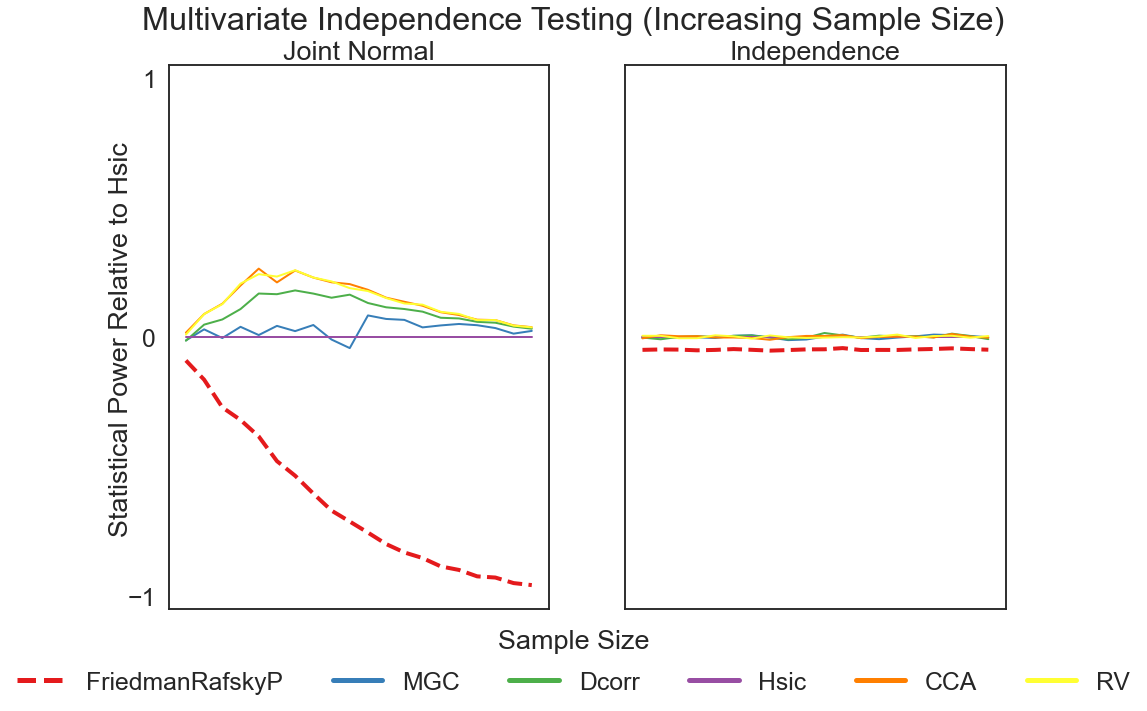

In [36]:
plot_power()